# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [1]:
#Regular EDA and plotting libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# We want our plots to appear in the notebook
%matplotlib inline

## Models
from tqdm import tqdm, trange
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE
import joblib
import gc

In [2]:
DATASET_DIRECTORY = 'CICIoT2023/'

In [3]:
# List all files in the directory
df_sets = [f for f in os.listdir(DATASET_DIRECTORY) if os.path.isfile(os.path.join(DATASET_DIRECTORY, f)) and f.endswith('.csv')]
df_sets.sort()
# Check if there's at least one CSV file
if df_sets:
    # Construct the full path of the first CSV file
    first_csv_file_path = os.path.join(DATASET_DIRECTORY, df_sets[0])
    
    # Read the first CSV file into a DataFrame
    df = pd.read_csv(first_csv_file_path)
    print(f"Loaded {first_csv_file_path} into DataFrame.")
else:
    print("No CSV files found in the directory.")


Loaded CICIoT2023/part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv into DataFrame.


### Importing Dataset

In [5]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',
]
y_column = 'label'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[X_columns], df[y_column], test_size=0.2, random_state=42)

### Scaling

In [7]:
scaler = StandardScaler()

In [8]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classification: 2 (1+1) Classes

In [9]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [10]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# 2. Class Balancing using SMOTE

smote = SMOTE(random_state=42, k_neighbors=4)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [16]:
# Define the models
ML_models = [
    LogisticRegression(n_jobs=-1),
    Perceptron(),
    AdaBoostClassifier(),
    RandomForestClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]

# Define the model names
ML_names = [
    "LogisticRegression",
    "Perceptron",
    "AdaBoost",
    "RandomForest",
    "DecisionTree"
]

In [19]:
# 3. Model Training and Evaluation

# Initialize the metrics_store_2classes dictionary
metrics_store_2classes = {}

for model, name in zip(ML_models, ML_names):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    metrics_store_2classes[name] = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }
    
    
    print(f"##### {name} #####")
    print(classification_report(y_test, y_pred))
    print('accuracy_score: ', accuracy)
    print('recall_score: ', recall)
    print('precision_score: ', precision)
    print('f1_score: ', f1)
    print("\n" * 3)
    print("Saving model metrics...")
# Save the metrics to a file
joblib.dump(metrics_store_2classes, "all_models_evaluation_metrics.sav")
print("Metrics saved to file.")

/home/sc/0.DCU/00.Project/ML_based_IDS_for_IoT/project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### LogisticRegression #####
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00         1
          BenignTraffic       0.86      0.54      0.66      1118
       BrowserHijacking       0.00      0.00      0.00         3
       CommandInjection       0.00      0.00      0.00         5
 DDoS-ACK_Fragmentation       0.94      0.98      0.96       311
        DDoS-HTTP_Flood       0.17      0.58      0.27        38
        DDoS-ICMP_Flood       1.00      1.00      1.00      7494
DDoS-ICMP_Fragmentation       0.99      0.97      0.98       494
      DDoS-PSHACK_Flood       1.00      1.00      1.00      4175
       DDoS-RSTFINFlood       1.00      1.00      1.00      4072
         DDoS-SYN_Flood       0.67      0.93      0.78      4248
         DDoS-SlowLoris       0.14      0.61      0.23        28
DDoS-SynonymousIP_Flood       0.76      0.65      0.70      3525
         DDoS-TCP_Flood       0.66      0.86      0.75    

##### DecisionTree #####
                         precision    recall  f1-score   support

       Backdoor_Malware       0.33      1.00      0.50         1
          BenignTraffic       0.92      0.87      0.89      1118
       BrowserHijacking       0.20      0.67      0.31         3
       CommandInjection       0.50      0.60      0.55         5
 DDoS-ACK_Fragmentation       0.99      0.99      0.99       311
        DDoS-HTTP_Flood       0.86      1.00      0.93        38
        DDoS-ICMP_Flood       1.00      1.00      1.00      7494
DDoS-ICMP_Fragmentation       0.99      1.00      0.99       494
      DDoS-PSHACK_Flood       1.00      1.00      1.00      4175
       DDoS-RSTFINFlood       1.00      1.00      1.00      4072
         DDoS-SYN_Flood       1.00      1.00      1.00      4248
         DDoS-SlowLoris       0.86      0.89      0.88        28
DDoS-SynonymousIP_Flood       1.00      1.00      1.00      3525
         DDoS-TCP_Flood       1.00      1.00      1.00      4596

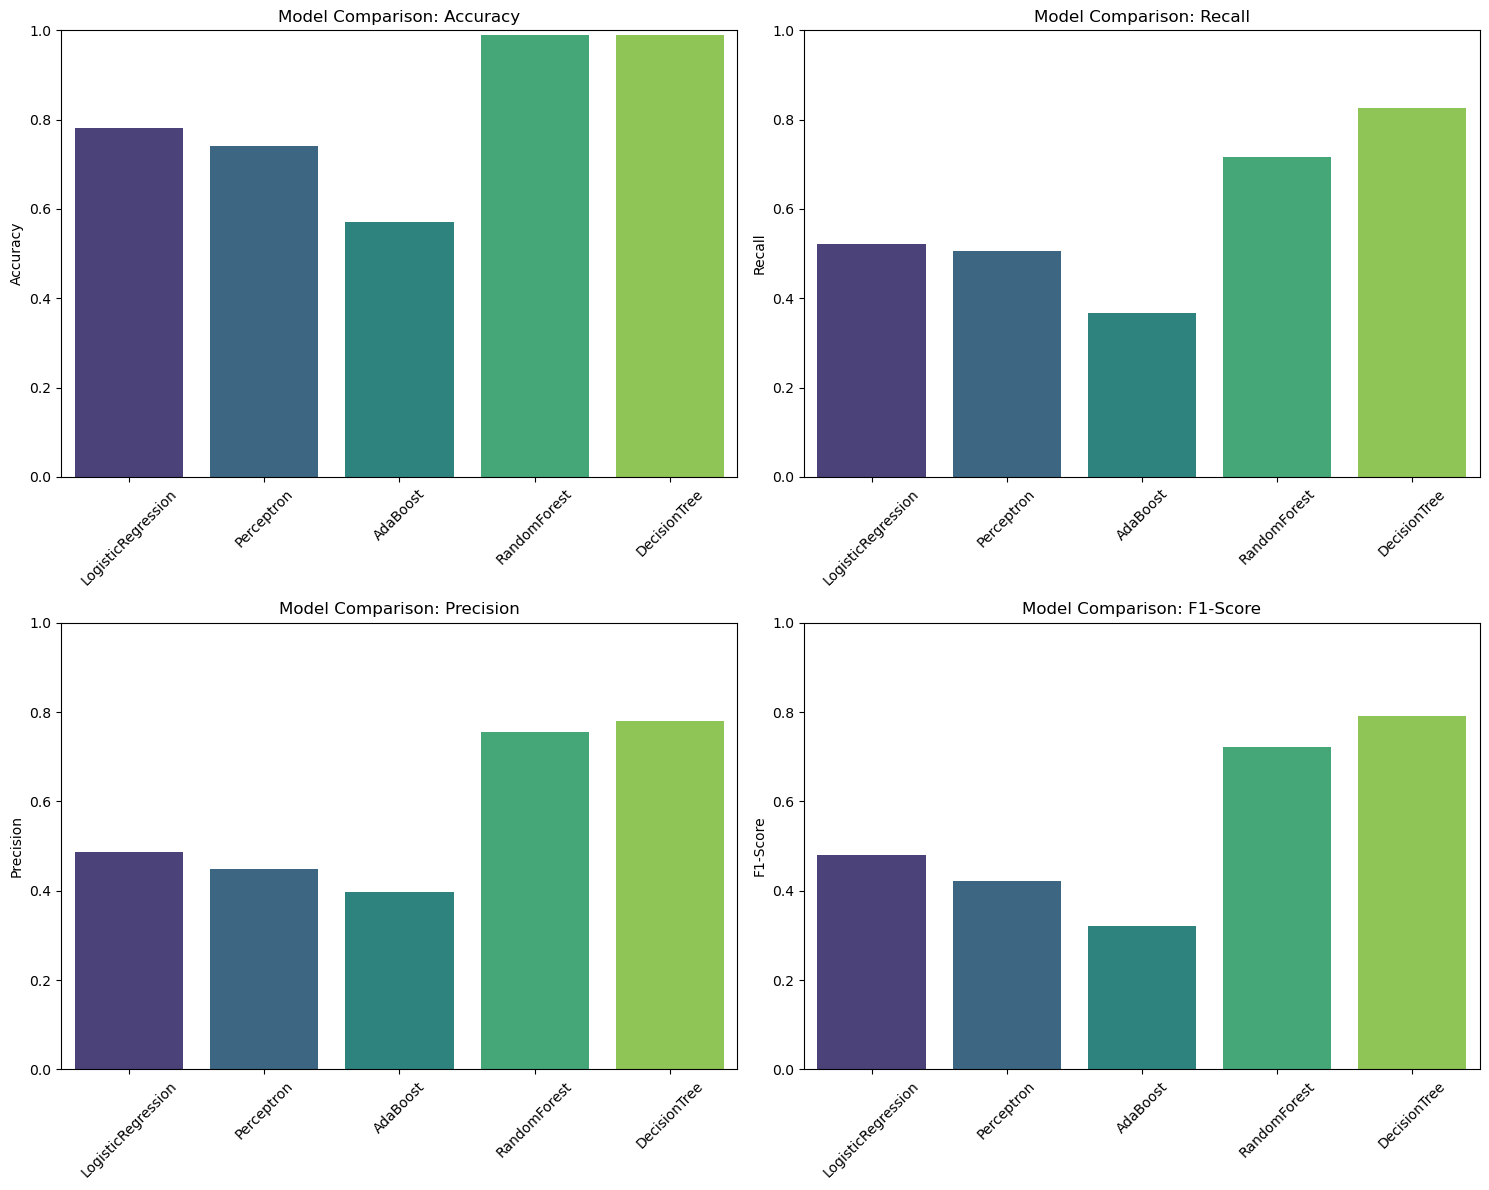

In [21]:
# Load the saved metrics from the joblib file
metrics_store_2classes = joblib.load("all_models_evaluation_metrics.sav")

# Extract metrics from the loaded data
accuracies = [metrics_store_2classes[model]['accuracy'] for model in ML_names]
recalls = [metrics_store_2classes[model]['recall'] for model in ML_names]
precisions = [metrics_store_2classes[model]['precision'] for model in ML_names]
f1_scores = [metrics_store_2classes[model]['f1'] for model in ML_names]

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Define metrics and their names for plotting
metrics = [accuracies, recalls, precisions, f1_scores]
metric_names = ['Accuracy', 'Recall', 'Precision', 'F1-Score']

# Plot each metric
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=ML_names, y=metric, palette="viridis")
    plt.title(f'Model Comparison: {metric_name}')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Since all metrics are in the range [0, 1]

plt.tight_layout()
plt.show()
